Step 1: Get config

In [2]:
import sys, os
from pathlib import Path
import importlib
from models import flooding_model

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.colors import ListedColormap


experiment_name = "WFV1_unet"
# Download val folder
path_to_dataset_folder = '.'
dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
val_folder = os.path.join(dataset_folder, "val")

folder_name_model_weights = os.path.join(path_to_dataset_folder, experiment_name)

if not os.path.exists(folder_name_model_weights):
    import gdown
    gdown.download_folder(id="1Oup-qVD1U-re3lIQkw7TOKJsdu90blsk", quiet=False, use_cookies=False,
                          output=folder_name_model_weights)

if not os.path.exists(val_folder):
    import gdown
    os.makedirs(val_folder, exist_ok=True)
    # https://drive.google.com/drive/folders/1ogcNupGr0q6nLwS7BBQQ8PzILyONah12?usp=sharing
    gdown.download_folder(id="1ogcNupGr0q6nLwS7BBQQ8PzILyONah12", quiet=False, use_cookies=False,
                          output=val_folder)

In [3]:
from ml4floods.models.config_setup import get_default_config

config_fp = "./train_models/new_1015/config_rgbnir_worldfloodsup_res2vtunet.json"
config = get_default_config(config_fp)
config.data_params.data_params='ml4cc_data_lake'

Loaded Config for experiment:  new_1015
{   'data_params': {   'batch_size': 40,
                       'bucket_id': '',
                       'channel_configuration': 'bgri',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 16,
                       'path_to_splits': '/mnt/d/Flooding//worldfloods_v1_0',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '/mnt/d/Flooding/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]},
    'experiment_n

Step 2: Load pre-trained model

In [4]:
from pytorch_lightning.utilities.cloud_io import load
from models.flooding_model import WorldFloodsModel2, WorldFloodsModel_Sup, WorldFloodsModel
importlib.reload(flooding_model)

model = WorldFloodsModel_Sup(config.model_params)
path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgbnir_worldfloodsup_res2vtunet.pt").replace("\\","/")


print(path_to_models)
model.load_state_dict(load(path_to_models))
model

model.eval()
model.to("cuda:1") # comment this line if your machine does not have GPU

train_models/new_1015/model_rgbnir_worldfloodsup_res2vtunet.pt


/home/hsu/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/cloud_io.py:41: LightningDeprecationWarning: `pytorch_lightning.utilities.cloud_io.load` has been deprecated in v1.8.0 and will be removed in v2.0.0. This function is internal but you can copy over its implementation.
  rank_zero_deprecation(


WorldFloodsModel_Sup(
  (network): Res2VTUnet(
    (h): RGB2HSV()
    (h_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (in_conv): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (cvt1): CvTblock(
      (conv_embed): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(4, 4), padding=(1, 1))
        (1): Rearrange('b c h w -> b (h w) c', h=64, w=64)
        (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (hue_embed): Sequential(
        (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(4, 4), padding=(1, 1))
        (1): Rearrange('b c h w -> b (h w) c', h=64, w=64)
        (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (transformer): Sequential(
        (0): Trans_depth(
          (layers): ModuleList(
            (0): TransformerBlock(
              (mha): Res2Attention(
                (res2): Res2Net(
                  (inconv): Sequential(
                    (0): Conv2d

In [5]:
from ml4floods.models.model_setup import get_model_inference_function
# from ml4.model_setup import get_model_inference_function

inference_function = get_model_inference_function(model, config,apply_normalization=True)

Getting model inference function


Step 3: Run Inference

In [ ]:
def slice_tensor(tensor, size):
    slices = []
    _, height, width = tensor.shape
    x_slices = (width ) // size 
    y_slices = (height ) // size

    for i in range(x_slices):
        for j in range(y_slices):
            left = i * size
            upper = j * size
            right = min(left + size, width)
            lower = min(upper + size, height)
            slice = tensor[:, upper:lower, left:right]
            # print(slice.shape)
            slices.append(slice)

    return slices


def combine_slices(slices, tensor_size):
    _, height, width = tensor_size    
    x_slices = (width) // slices[0].shape[2] 
    y_slices = (height) // slices[0].shape[1] 
    combined_tensor = torch.zeros(3,height , width)
    
    for i in range(x_slices):
        for j in range(y_slices):
            slice_index = i * y_slices + j
            slice = slices[slice_index]
            left = i * slice.shape[2]
            upper = j * slice.shape[1]
            combined_tensor[:, upper:upper+slice.shape[1], left:left+slice.shape[2]] = slice

    return combined_tensor

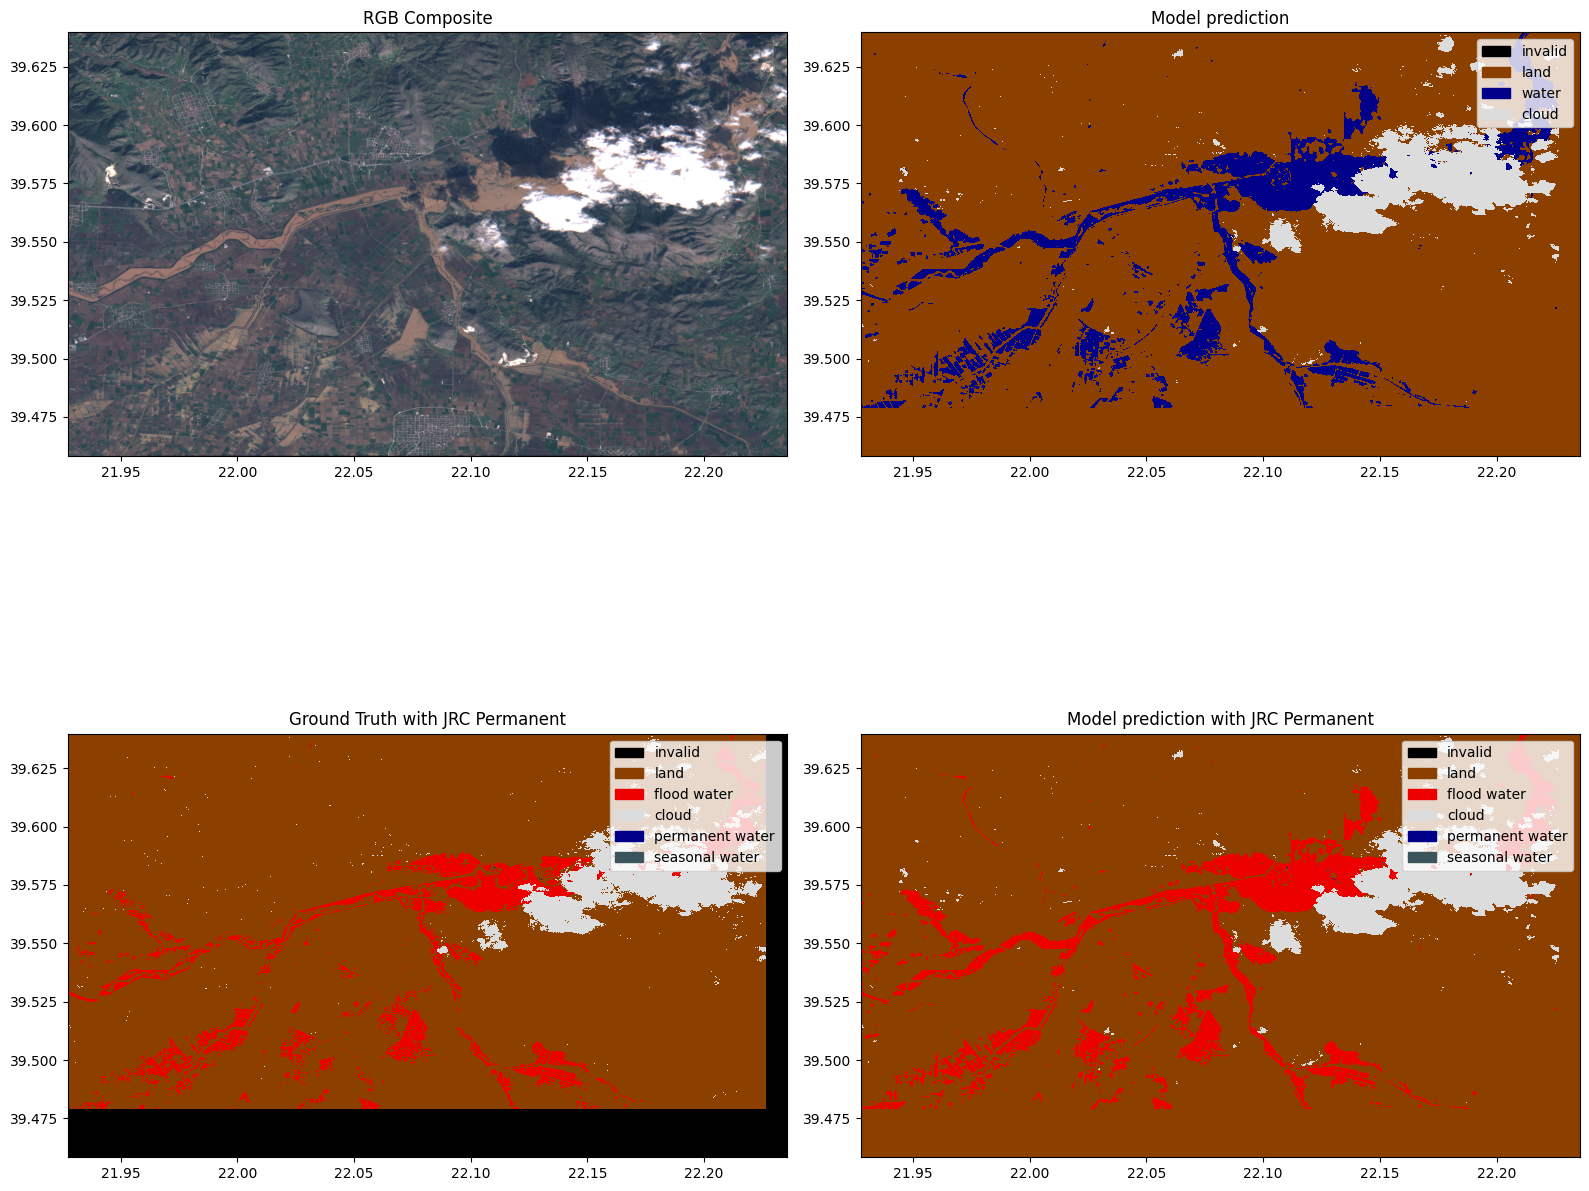

In [14]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt

channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    outs.append(outputs)
recombined_image = combine_slices(outs, torch_inputs.shape)    

prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])
sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)   


# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[0,1])
axs[0,1].set_title("Model prediction")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1_with_permanent(prediction.unsqueeze(0), recombined_water, window=window, transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction with JRC Permanent")
plt.tight_layout()

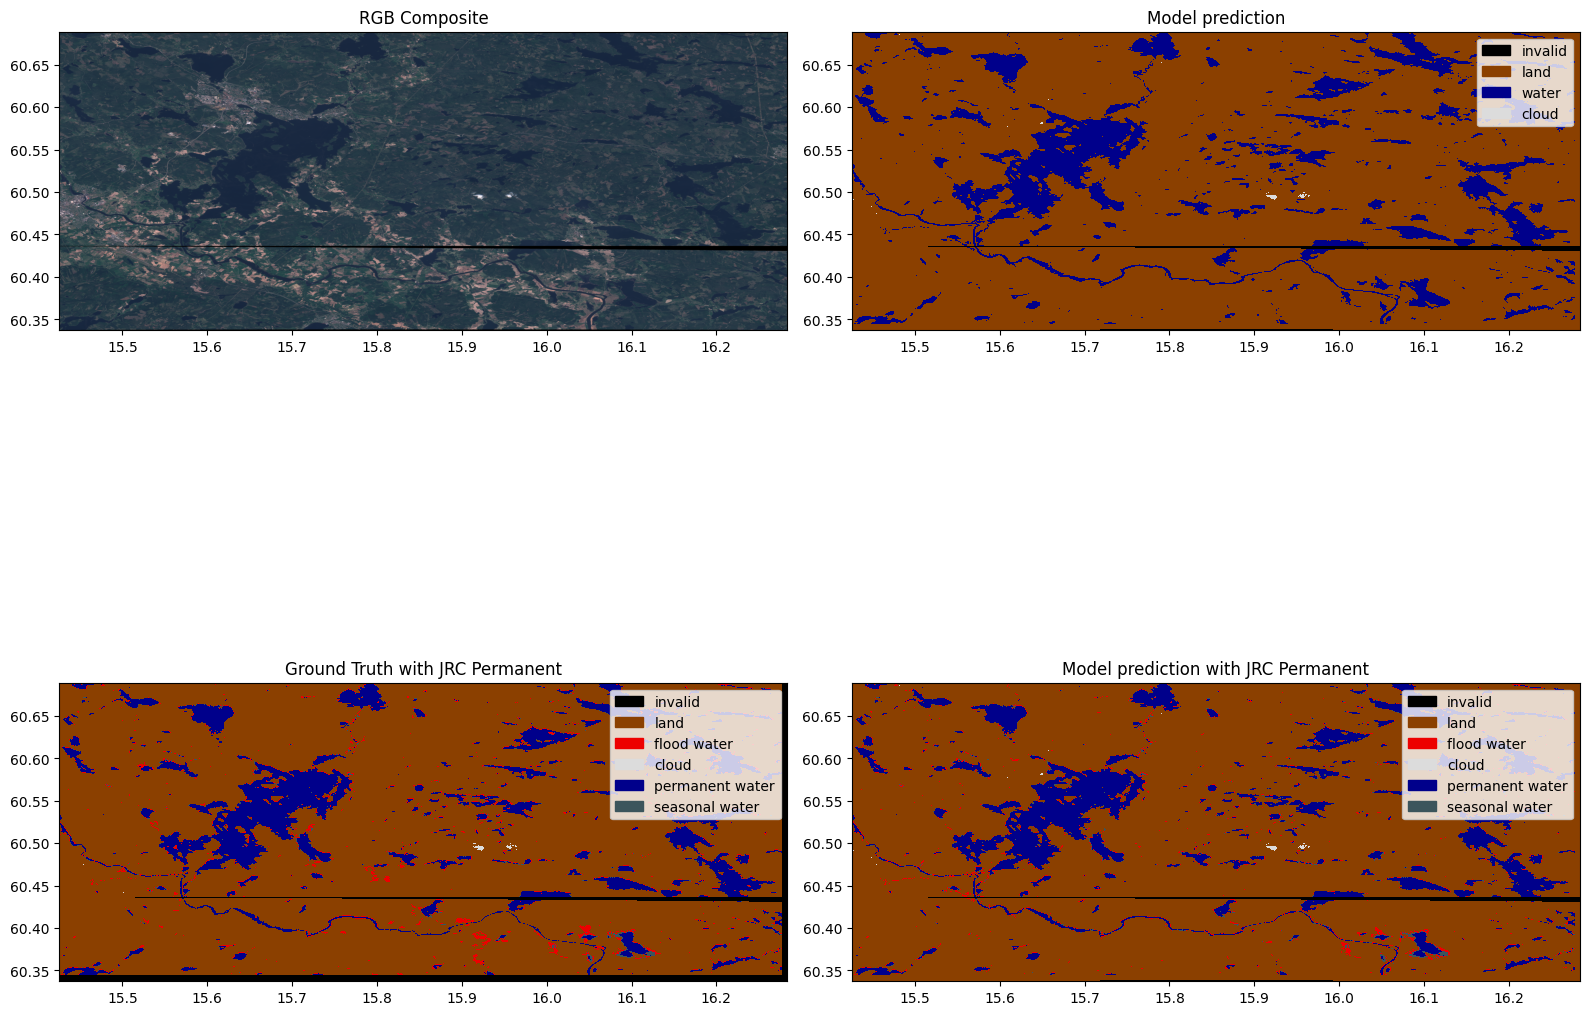

In [18]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt

channel_configuration = config.model_params.hyperparameters.channel_configuration
dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "EMSR280_03FALUN_DEL_MONIT06_v2_observed_event_a.tif"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    outs.append(outputs)
recombined_image = combine_slices(outs, torch_inputs.shape)    

prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])
sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)   

# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[0,1])
axs[0,1].set_title("Model prediction")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1_with_permanent(prediction.unsqueeze(0), recombined_water, window=window, transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction with JRC Permanent")
plt.tight_layout()

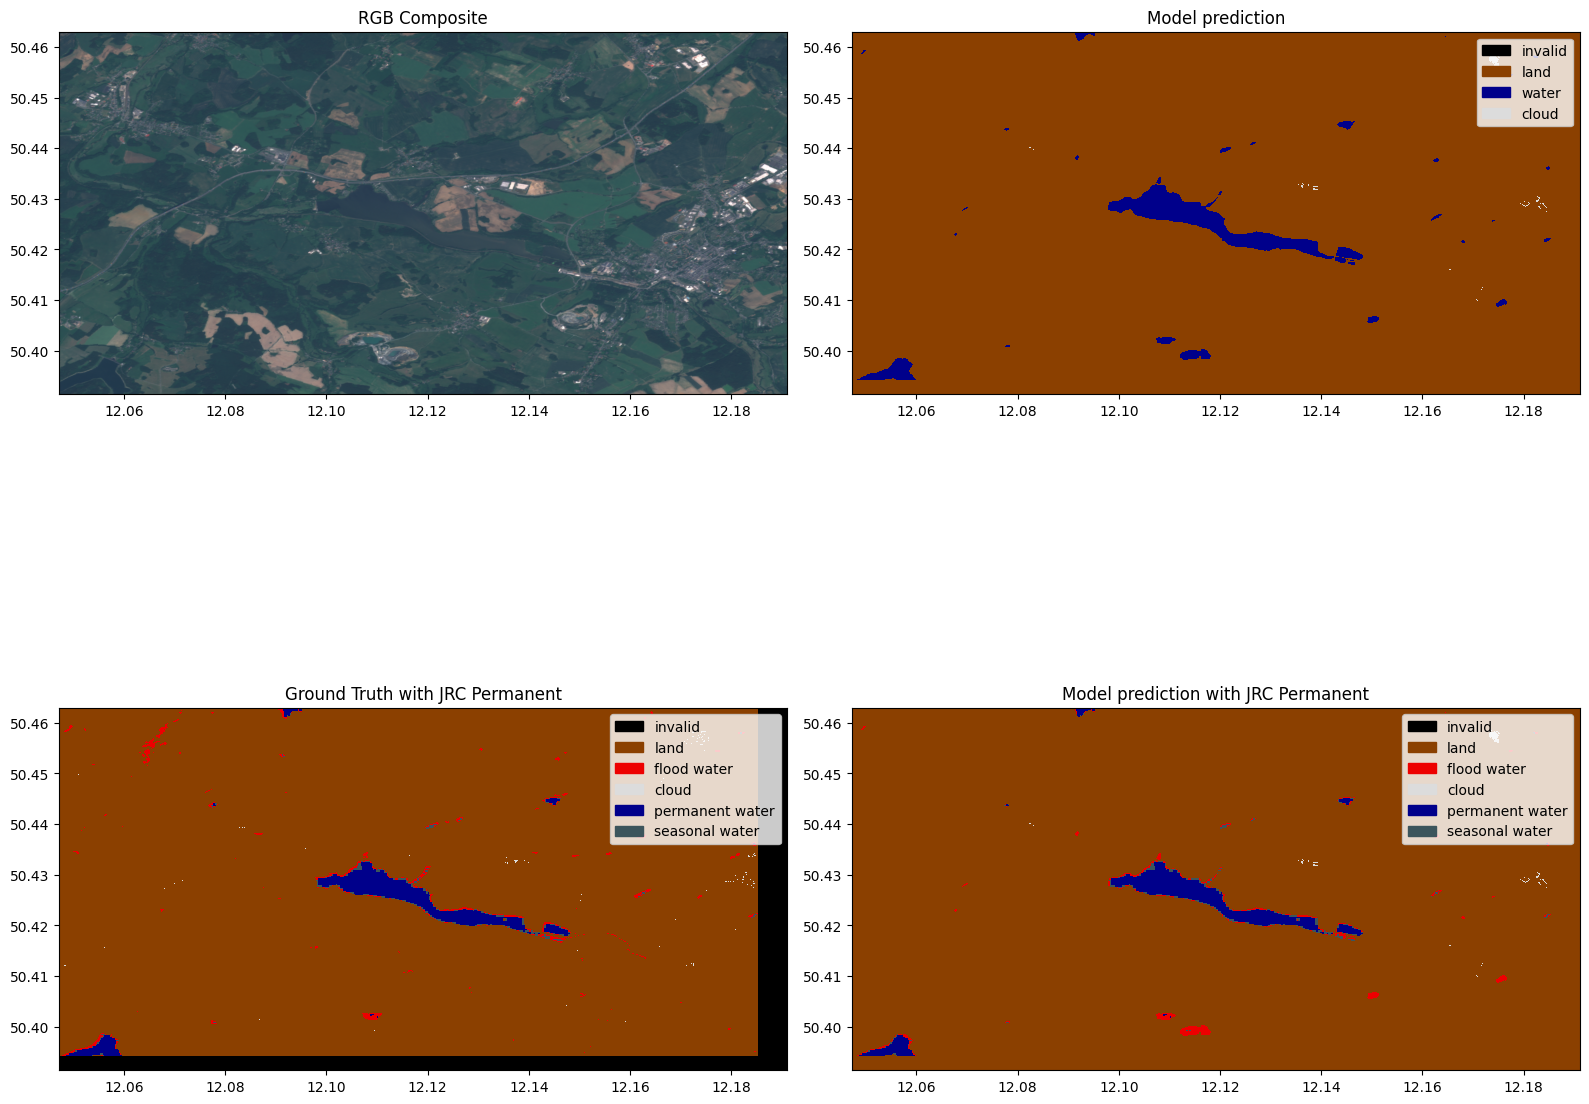

In [21]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt

channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "EMSR287_05MAGWITZ_DEL_v1_observed_event_a.tif"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    outs.append(outputs)
recombined_image = combine_slices(outs, torch_inputs.shape)    

prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])
sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)   

# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[0,1])
axs[0,1].set_title("Model prediction")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1_with_permanent(prediction.unsqueeze(0), recombined_water, window=window, transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction with JRC Permanent")
plt.tight_layout()

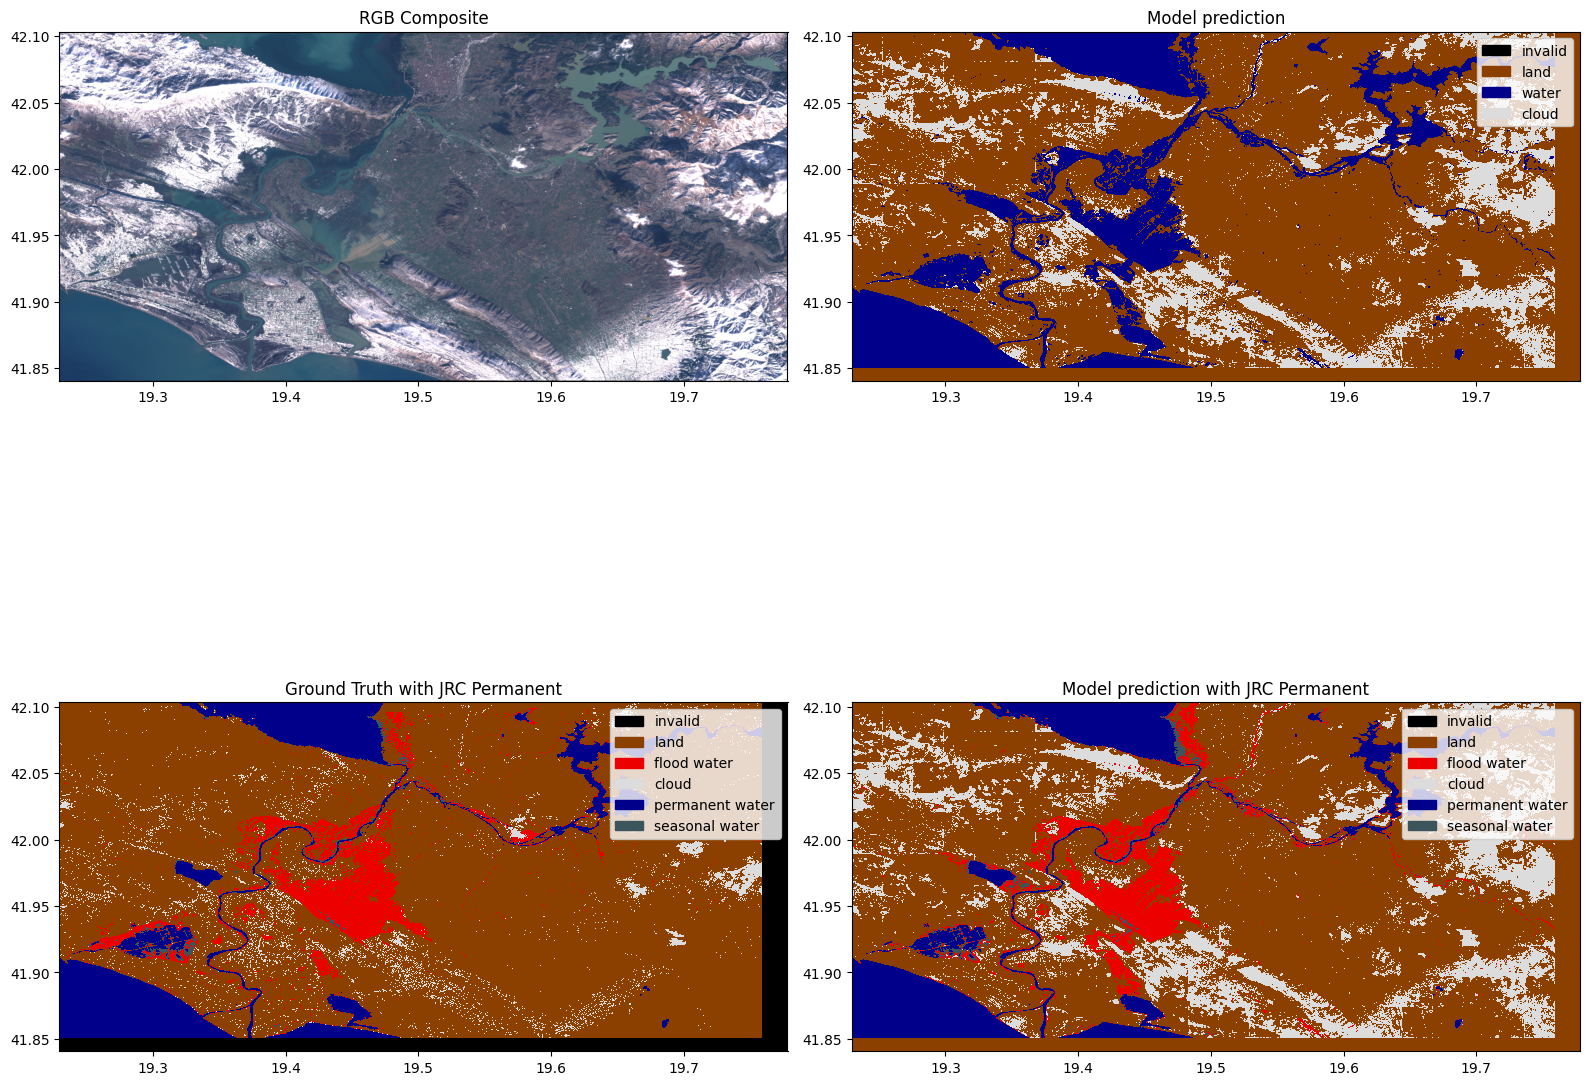

In [24]:
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt
channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = "./worldfloods_v1_0_sample/"
event_id = "EMSR501_AOI01_DEL_MONIT01_r1_v1.tif"
tiff_s2 = os.path.join(dataset_folder, "tiffs_for_inference", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "tiffs_for_inference", "GT","V_1_1", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "tiffs_for_inference", "JRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)
# Make predictions
sliced_images = slice_tensor(torch_inputs, size=256)
outs = []
for i in sliced_images:
    outputs = inference_function(i.unsqueeze(0))[0] # (num_classes, h, w)
    outs.append(outputs)
recombined_image = combine_slices(outs, torch_inputs.shape)    

prediction = torch.argmax(recombined_image, dim=0).long() # (h, w)
# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])
sliced_floods = slice_tensor(torch_targets, size=256)
recombined_floods = combine_slices(sliced_floods, torch_inputs.shape)    
sliced_water = slice_tensor(torch_permanent_water, size=256)
recombined_water = combine_slices(sliced_water, torch_inputs.shape)   

# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs.squeeze(0), transform=transform, ax=axs[0,0], channel_configuration=channel_configuration)
axs[0,0].set_title("RGB Composite")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[0,1])
axs[0,1].set_title("Model prediction")
plot_utils.plot_gt_v1_with_permanent(recombined_floods, recombined_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1_with_permanent(prediction.unsqueeze(0), recombined_water, window=window, transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction with JRC Permanent")
plt.tight_layout()